# Testing diffusion problem format

Grid and parameters

In [1]:
using Plots
using SparseArrays, LinearAlgebra

In [2]:
struct Grid
    xmax::Float64
    ymax::Float64

    nx::Int64
    ny::Int64
    
    Δx::Float64
    Δy::Float64

    xRange::Array{Float64,1}
    yRange::Array{Float64,1}

    function Grid(xmax, ymax, nx, ny)
        Δx = 2*xmax/(nx-1)
        Δy = 2*ymax/(ny-1)

        xRange = (-xmax:Δx:xmax)
        yRange = (-ymax:Δy:ymax)

        return new(xmax, ymax, nx, ny, Δx, Δy, xRange, yRange)
    end
end
struct Parameters
    ν::Float64
    σ::Float64
    tspan::Tuple{Float64,Float64}
end

Model setup

In [3]:
abstract type FluidModel end
mutable struct DiffusionModel{T<:Union{Function,Nothing}} <: FluidModel
    u0::Array{Float64,2}
    u_analytic::T
    
    grid::Grid
    parameters::Parameters
    
    Δt::Float64
    t::Array{Float64,1}
    
    function DiffusionModel(u0, u_analytic::T, grid, parameters) where T<:Union{Function,Nothing}
        Δt = parameters.σ*grid.Δx*grid.Δy/parameters.ν
        t = parameters.tspan[1]:Δt:parameters.tspan[2]
        return new{T}(u0, u_analytic, grid, parameters, Δt ,t)
    end
end
DiffusionModel(grid, parameters) = DiffusionModel(zeros(grid.ny, grid.nx), nothing, grid, parameters)
DiffusionModel(u0, grid, parameters) = DiffusionModel(u0, nothing, grid, parameters);

Test setup of model

In [4]:
function make_gaussian(grid::Grid)
    u0 = zeros(grid.ny, grid.nx)
    x = grid.xRange
    y = grid.yRange
    
    x₀ = 0.0
    y₀ = 0.0
    var₀ = 0.9
    T₀ = 1.0
    for j = 1 : grid.ny, i = 1 : grid.nx
        u0[j,i] = T₀*exp(-((x[i]-x₀)^2 + (y[j]-y₀)^2)/(2*var₀))
    end
    return u0
end
function solution_gaussian(grid::Grid, t, κ)
    uana = zeros(grid.ny, grid.nx)
    x = grid.xRange
    y = grid.yRange
    
    x₀ = 0.0
    y₀ = 0.0
    var₀ = 0.9
    T₀ = 1.0
    #t₀ = -0.1
    
    for j = 1 : grid.ny, i = 1 : grid.nx
        uana[j,i] = T₀/sqrt(1+4*κ*t/var₀)*
                exp(-((x[i]-x₀)^2 + (y[j]-y₀)^2)/(2*var₀+4*κ*t))
        #uana[j,i] = 1/sqrt(4*pi*κ*(t-t₀))*
        #        exp(-((x[i]-x₀)^2 + (y[j]-y₀)^2)/(4*pi*κ*(t-t₀)))
    end
    return uana
end;

In [5]:
grid_test = Grid(5., 5., 64, 64)
param_test = Parameters(1.44, 0.01, (0.0, 0.1))
u0_test = make_gaussian(grid_test)
#u0_test = solution_gaussian(grid_test, 0, -0.05, param_test.ν)
uana_test(t) = solution_gaussian(grid_test, t, param_test.ν)

mod_test = DiffusionModel(u0_test, uana_test, grid_test, param_test)
#mod_test = DiffusionModel(u0_test, grid_test, param_test)
dump(mod_test)

DiffusionModel{typeof(uana_test)}
  u0: Array{Float64}((64, 64)) [8.635040753377376e-13 2.056653577206363e-12 … 2.056653577206363e-12 8.635040753377376e-13; 2.056653577206363e-12 4.8984411972593484e-12 … 4.8984411972593484e-12 2.056653577206363e-12; … ; 2.056653577206363e-12 4.8984411972593484e-12 … 4.8984411972593484e-12 2.056653577206363e-12; 8.635040753377376e-13 2.056653577206363e-12 … 2.056653577206363e-12 8.635040753377376e-13]
  u_analytic: uana_test (function of type typeof(uana_test))
  grid: Grid
    xmax: Float64 5.0
    ymax: Float64 5.0
    nx: Int64 64
    ny: Int64 64
    Δx: Float64 0.15873015873015872
    Δy: Float64 0.15873015873015872
    xRange: Array{Float64}((64,)) [-5.0, -4.841269841269841, -4.682539682539683, -4.523809523809524, -4.365079365079365, -4.2063492063492065, -4.0476190476190474, -3.888888888888889, -3.7301587301587302, -3.5714285714285716  …  3.5714285714285716, 3.7301587301587302, 3.888888888888889, 4.0476190476190474, 4.2063492063492065, 4.365079365

0.9930257495086255


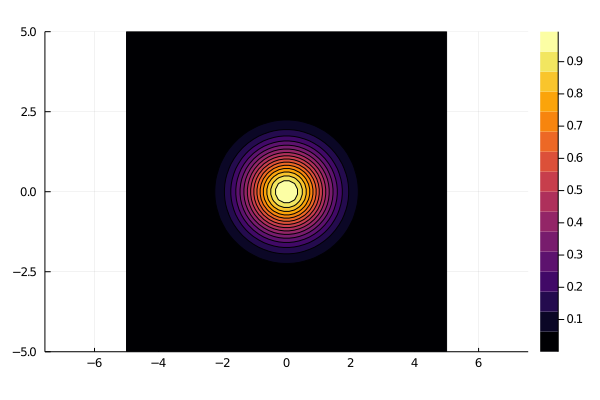

In [6]:
println(maximum(u0_test))
contourf(grid_test.xRange, grid_test.yRange, u0_test, aspect_ratio=:equal)

0.9930257495086255


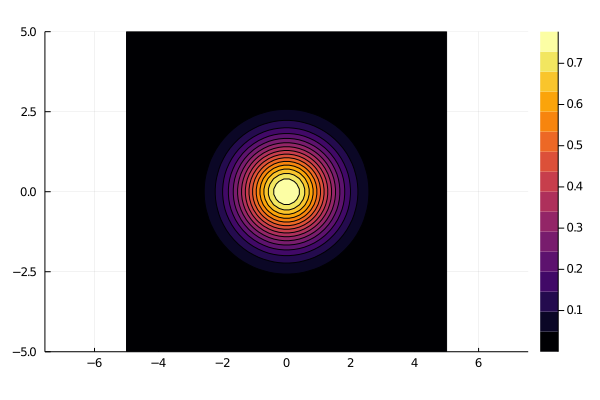

In [7]:
println(maximum(uana_test(0.0)))
contourf(grid_test.xRange, grid_test.yRange, uana_test(0.1), aspect_ratio=:equal)

# Solving methods

1. Cache

In [8]:
abstract type DiffusionCache end
mutable struct ExplicitDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uprev::Array{Float64,2}
    t::Float64
end
# NOTE: Add types for a matrices
mutable struct CNDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uprev::Array{Float64,2}
    rhs::Array{Float64,2}
    a1
    a2
    t::Float64
end
mutable struct ADIDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uhalf::Array{Float64,2}
    uprev::Array{Float64,2}
    rhs::Array{Float64,2}
    a1x
    a1y
    a2x
    a2y
    t::Float64
end

Methods

In [9]:
abstract type DiffusionMethod end
struct ExplicitDiffusion <: DiffusionMethod end
struct CrankNickolsonDiffusion <: DiffusionMethod end
struct ADIDiffusion <: DiffusionMethod end

In [10]:
function perform_step!(model::DiffusionModel, method::ExplicitDiffusion, cache::ExplicitDiffusionCache)
    u  = cache.u
    un = cache.uprev
    nx = model.grid.nx
    ny = model.grid.ny
    Δx = model.grid.Δx
    Δy = model.grid.Δy
    Δt = model.Δt
    ν  = model.parameters.ν
    
    copy!(un,u)
    @inbounds for j in 2:ny-1, i in 2:nx-1
        u[j,i] = un[j,i] + 
            ν*Δt/(Δx*Δx)*(un[j  ,i+1]-2*un[j,i]+un[j  ,i-1]) + 
            ν*Δt/(Δy*Δy)*(un[j+1,i  ]-2*un[j,i]+un[j-1,i  ])
    end
    
    return nothing
end
function perform_step!(model::DiffusionModel, method::CrankNickolsonDiffusion, cache::CNDiffusionCache)
    u   = cache.u
    un  = cache.uprev
    rhs = cache.rhs
    a1  = cache.a1
    a2  = cache.a2
    
    copy!(un,u)
    
    unV = @view un[2:end-1,2:end-1]
    unVC = @view unV[:]
    uV = @view u[2:end-1,2:end-1]
    uVC = @view uV[:]
    rhsV = @view rhs[2:end-1,2:end-1]
    rhsVC = @view rhsV[:]

    mul!(rhsVC, a2, unVC)
    uVC .= a1\rhsV[:]

    return nothing
end
function perform_step!(model::DiffusionModel, method::ADIDiffusion, cache::ADIDiffusionCache)
    u      = cache.u
    uhalf  = cache.uhalf
    un     = cache.uprev
    rhs    = cache.rhs
    a1x    = cache.a1x
    a1y    = cache.a1y
    a2x    = cache.a2x
    a2y    = cache.a2y
    nx, ny = model.grid.nx, model.grid.ny
    
    copy!(un,u)
  
    un_i(i) = @view un[2:end-1,i]
    u_i(i) = @view u[2:end-1,i]
    rhs_j(j) = @view rhs[j,2:end-1]
    rhs_i(i) = @view rhs[2:end-1,i]
    uhalf_j(j) = @view uhalf[j,2:end-1]

    # Step one
    for i = 2:nx-1
        mul!(rhs_i(i), a2y, un_i(i))
    end
    for j = 2:ny-1
        ldiv!(uhalf_j(j), a1x, rhs_j(j))
    end

    # Step two
    for j = 2:ny-1
        mul!(rhs_j(j), a2x, uhalf_j(j))
    end
    for i = 2:nx-1
        ldiv!(u_i(i), a1y, rhs_i(i))
    end
    return nothing
end
function apply_BCs!(cache)
    u = cache.u
    u[1,:]   .= 0.0
    u[end,:] .= 0.0
    u[:,1]   .= 0.0
    u[:,end] .= 0.0
    return nothing
end;

In [11]:
# Cache initialisers
init_cache(model, method::ExplicitDiffusion) = 
    ExplicitDiffusionCache(copy(model.u0), copy(model.u0), copy(model.parameters.tspan[1]))
function init_cache(model, method::CrankNickolsonDiffusion)
    u     = copy(model.u0)
    uprev = copy(model.u0)
    rhs   = copy(model.u0)
    
    a1, a2 = init_CN(model)
    
    t = copy(model.parameters.tspan[1])
    
    return CNDiffusionCache(u, uprev, rhs, a1, a2, t);
end
function init_cache(model, method::ADIDiffusion)
    u     = copy(model.u0)
    uhalf = copy(model.u0)
    uprev = copy(model.u0)
    rhs   = copy(model.u0)
    
    a1x, a1y, a2x, a2y = init_ADI(model)
    
    t = copy(model.parameters.tspan[1])
    
    return ADIDiffusionCache(u, uhalf, uprev, rhs, a1x, a1y, a2x, a2y, t);
end;

In [12]:
# Matrix solvers
function init_CN(model)
    nx, ny = model.grid.nx, model.grid.ny
    Δx, Δy = model.grid.Δx, model.grid.Δy
    ν, Δt  = model.parameters.ν, model.Δt
    
    Nx = (nx-2)
    Ny = (ny-2)
    Nxy = Nx*Ny
    βx = 0.5*ν*Δt/(Δx*Δx)
    βy = 0.5*ν*Δt/(Δy*Δy)

    # New a1
    a1 = spzeros(Nxy,Nxy)
    ij_ind = LinearIndices((1:Ny, 1:Nx))
    for ij in ij_ind
        a1[ij,ij] = 1 + 2*βx + 2*βy
    end
    for ij in 1:Nx*(Ny-1)
        a1[view(ij_ind,2:Ny,:)[ij],view(ij_ind,1:Ny-1,:)[ij]] = -βy # Up
        a1[view(ij_ind,1:Ny-1,:)[ij],view(ij_ind,2:Ny,:)[ij]] = -βy # Down
    end
    for ij in 1:(Nx-1)*Ny
        a1[view(ij_ind,:,2:Nx)[ij],view(ij_ind,:,1:Nx-1)[ij]] = -βx # Right
        a1[view(ij_ind,:,1:Nx-1)[ij],view(ij_ind,:,2:Nx)[ij]] = -βx # Left
    end

    # New a2
    a2 = spzeros(Nxy,Nxy)
    ij_ind = LinearIndices((1:Ny, 1:Nx))
    for ij in ij_ind
        a2[ij,ij] = 1 - 2*βx - 2*βy
    end
    for ij in 1:Nx*(Ny-1)
        a2[view(ij_ind,2:Ny,:)[ij],view(ij_ind,1:Ny-1,:)[ij]] = βy # Up
        a2[view(ij_ind,1:Ny-1,:)[ij],view(ij_ind,2:Ny,:)[ij]] = βy # Down
    end
    for ij in 1:(Nx-1)*Ny
        a2[view(ij_ind,:,2:Nx)[ij],view(ij_ind,:,1:Nx-1)[ij]] = βx # Right
        a2[view(ij_ind,:,1:Nx-1)[ij],view(ij_ind,:,2:Nx)[ij]] = βx # Left
    end

    a1_lu = factorize(a1)
    return a1_lu, a2
end
function init_ADI(model)
    nx, ny = model.grid.nx, model.grid.ny
    Δx, Δy = model.grid.Δx, model.grid.Δy
    ν, Δt  = model.parameters.ν, model.Δt
    
    βx = 0.5*ν*Δt/(Δx*Δx)
    βy = 0.5*ν*Δt/(Δy*Δy)
    d1x = ones(nx-2) .+ 2 * βx
    e1x = -βx * ones(nx-3)
    d1y = ones(ny-2) .+ 2 * βy
    e1y = -βy * ones(ny-3)
    # matrix ( I - 0.5 nu dt delta_x^2 )
    a1x = SymTridiagonal(d1x,e1x)
    a1y = SymTridiagonal(d1y,e1y)

    d2x = ones(nx-2) .- 2 * βx
    e2x = -βx * ones(nx-3)
    d2y = ones(ny-2) .- 2 * βy
    e2y = -βy * ones(ny-3)
    # matrix ( I + 0.5 nu dt delta_x^2) 
    a2x = SymTridiagonal(d2x,-e2x)
    a2y = SymTridiagonal(d2y,-e2y)

    #LDLt factorize
    a1x_ldlt = factorize(a1x)
    a1y_ldlt = factorize(a1y)
    return a1x_ldlt, a1y_ldlt, a2x, a2y
end;

Problem = model + method + (cache)

In [13]:
abstract type FluidProblem end
mutable struct DiffusionProblem{MethodType<:DiffusionMethod, CacheType<:DiffusionCache} <: FluidProblem
    model::DiffusionModel
    method::MethodType
    cache::CacheType
end
function DiffusionProblem(model, M::MethodType) where MethodType
    cache = init_cache(model, M)
    CacheType = typeof(cache)
    return DiffusionProblem{MethodType, CacheType}(model, M, cache)
end;

In [14]:
abstract type FluidSolution end
mutable struct DiffusionSolution{T<:Union{Array{Float64,2},Nothing}} <: FluidSolution
    u::Array{Float64,2}
    
    u_analytic::T
    errors::T
    
    prob::DiffusionProblem
    retcode::Bool
end
function DiffusionSolution(prob::DiffusionProblem, retcode::Bool)
    u_analytic, errors = get_analytic(prob.model, prob.cache.u, prob.cache.t)
    return DiffusionSolution(prob.cache.u, u_analytic, errors, prob, retcode)
end
function get_analytic(model::DiffusionModel{T}, u, t) where T<:Function
    u_analytic = model.u_analytic(t)
    #println(t)
    errors = abs.(u - u_analytic)
    return u_analytic, errors
end
get_analytic(model::DiffusionModel{Nothing}, u, t) = nothing, nothing;

Solve problem

In [15]:
function solve(prob::DiffusionProblem)
    sol = solve!(prob)
    return sol
end
function solve!(prob::DiffusionProblem)
    while prob.cache.t < prob.model.parameters.tspan[2]
        #println(prob.cache.t)
        timestep!(prob)
    end
    return DiffusionSolution(prob, true)
end
function timestep!(prob::DiffusionProblem)
    prob.cache.t += prob.model.Δt
    perform_step!(prob.model, prob.method, prob.cache)
    #apply_BCs!(prob.cache)
    return nothing
end;

Initialise problem object

In [16]:
prob_test = DiffusionProblem(mod_test, ExplicitDiffusion())
#prob_test = DiffusionProblem(mod_test, CrankNickolsonDiffusion())
#prob_test = DiffusionProblem(mod_test, ADIDiffusion())
dump(prob_test)

DiffusionProblem{ExplicitDiffusion,ExplicitDiffusionCache}
  model: DiffusionModel{typeof(uana_test)}
    u0: Array{Float64}((64, 64)) [8.635040753377376e-13 2.056653577206363e-12 … 2.056653577206363e-12 8.635040753377376e-13; 2.056653577206363e-12 4.8984411972593484e-12 … 4.8984411972593484e-12 2.056653577206363e-12; … ; 2.056653577206363e-12 4.8984411972593484e-12 … 4.8984411972593484e-12 2.056653577206363e-12; 8.635040753377376e-13 2.056653577206363e-12 … 2.056653577206363e-12 8.635040753377376e-13]
    u_analytic: uana_test (function of type typeof(uana_test))
    grid: Grid
      xmax: Float64 5.0
      ymax: Float64 5.0
      nx: Int64 64
      ny: Int64 64
      Δx: Float64 0.15873015873015872
      Δy: Float64 0.15873015873015872
      xRange: Array{Float64}((64,)) [-5.0, -4.841269841269841, -4.682539682539683, -4.523809523809524, -4.365079365079365, -4.2063492063492065, -4.0476190476190474, -3.888888888888889, -3.7301587301587302, -3.5714285714285716  …  3.5714285714285716, 3.

Try solving

In [17]:
sol_test = solve(prob_test);

In [18]:
using BenchmarkTools
#@time solve(prob_test);
# 0.000365 seconds
# 0.968088 seconds
# 0.000901 seconds

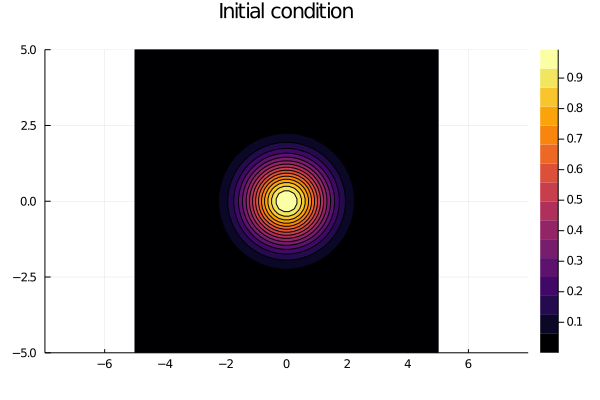

In [19]:
#prob_test.model.u0
contourf(grid_test.xRange, grid_test.yRange, prob_test.model.u0, 
         aspect_ratio=:equal, title="Initial condition")

Max: 0.7543051313832931


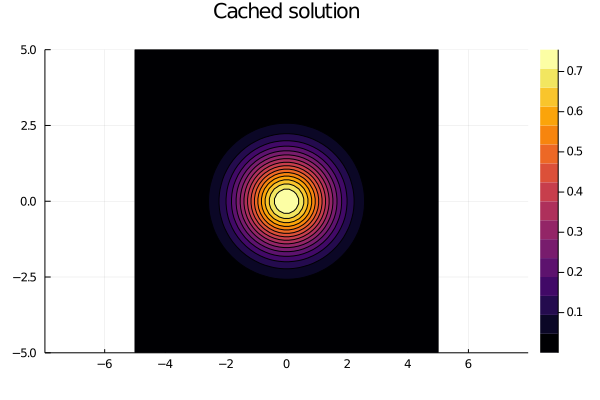

In [20]:
#prob_test.cache.u
println("Max: ", maximum(prob_test.cache.u))
contourf(grid_test.xRange, grid_test.yRange, prob_test.cache.u, 
         aspect_ratio=:equal, title="Cached solution")

Max: 0.7543051313832931


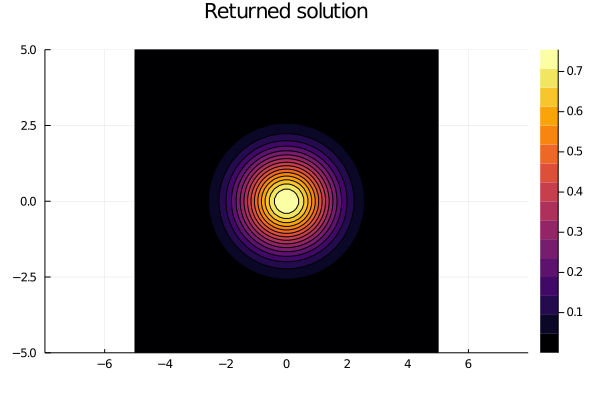

In [21]:
#sol_test.u
println("Max: ", maximum(sol_test.u))
contourf(grid_test.xRange, grid_test.yRange, sol_test.u, 
         aspect_ratio=:equal, title="Returned solution")

Max: 0.7766173699298365


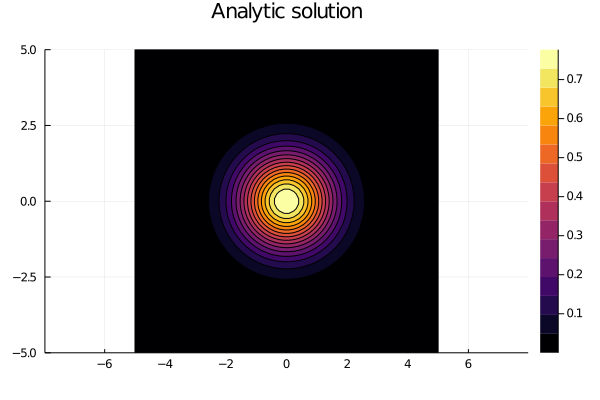

In [22]:
#sol_test.u_analytic
println("Max: ", maximum(sol_test.u_analytic))
contourf(grid_test.xRange, grid_test.yRange, sol_test.u_analytic, 
         aspect_ratio=:equal, title="Analytic solution")

Max error: 0.022312238546543406


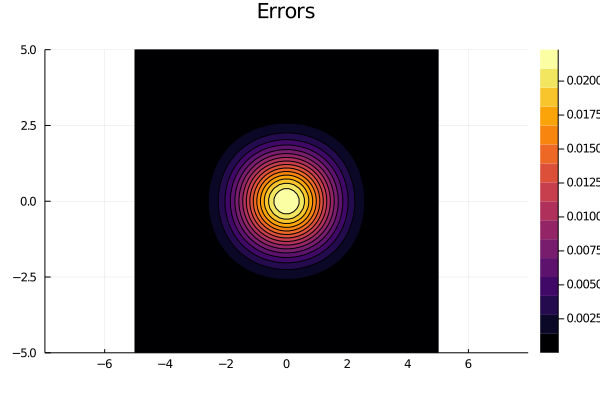

In [23]:
#sol_test.errors
println("Max error: ", maximum(sol_test.errors))
contourf(grid_test.xRange, grid_test.yRange, sol_test.errors, 
         aspect_ratio=:equal, title="Errors")

In [24]:
# sol = 0.7503074148181966 // 0.09798157946306095 + 0.00409626216077829
# ana = 0.7745194759544624 // 0.09798157946306095
maximum(uana_test(0.09798157946306095*1.20))

0.7515582339465188

## Work precision set

In [260]:
function error_vary_params(σ, nx, ny)
    grid_σ = Grid(1., 2., nx, ny)
    param_σ = Parameters(0.2, σ, (0.0, 0.02))
    u0_σ = make_gaussian(grid_σ)
    uana_test(t) = solution_gaussian(grid_σ, t, param_σ.ν)

    mod_σ = DiffusionModel(u0_σ, uana_test, grid_σ, param_σ)
    prob_σ = DiffusionProblem(mod_σ, ADIDiffusion())
    
    sol_timed = @timed solve(prob_σ)
    sol_σ = sol_timed[1]
    sol_time = sol_timed[2]
    
    abs_err = maximum(sol_σ.errors)
    #rel_err = abs_err/maximum(sol_σ.u_analytic)
    rel_err = maximum(sol_σ.u)/maximum(sol_σ.u_analytic)
    
    return sol_time, abs_err, rel_err
end;
function error_vector_σ(σ, error_fun)
    abs_errors = zeros(size(σ))
    rel_errors = zeros(size(σ))
    times = zeros(size(σ))
    for i in 1:length(abs_errors)
        times[i], abs_errors[i], rel_errors[i] = error_fun(σ[i])
    end
    return times, abs_errors, rel_errors
end;

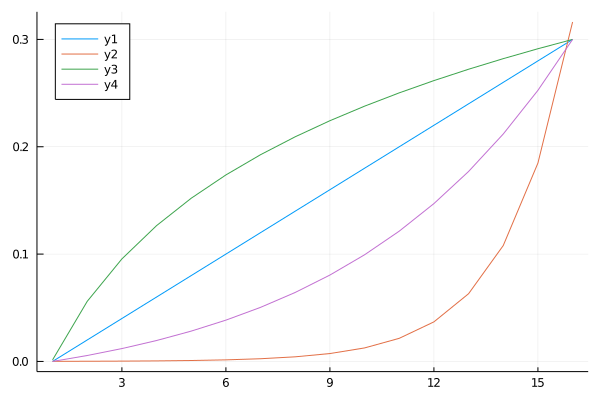

In [261]:
b = 1000
b2 = 10
σ_range1 = range(1e-5, 0.3, length = 16)
σ_range2 = 10 .^ range(-4, -0.5, length = 16)
σ_range3 = log.(b, range(1.01, b^0.3, length = 16))
σ_range4 = (b2 .^ range(0, 1, length = 16) .- 1 .+ 1e-4) / ((b2-1)/0.3)
plot(σ_range1, legend=:topleft)
plot!(σ_range2)
plot!(σ_range3)
plot!(σ_range4)

In [296]:
#σ_range = (10 .^ range(0, 1, length = 4) .- 1 .+ 1e-4) / ((10-1)/0.3)
#σ_range = range(0.0001, 2.0, length = 32)
σ_range = (10 .^ range(0, 1, length = 64) .- 1 .+ 0.0001) / ((10-1)/2)
error_vary_σ_8x16(σ) = error_vary_params(σ, 8, 16)
error_vary_σ_16x32(σ) = error_vary_params(σ, 16, 32)
error_vary_σ_32x64(σ) = error_vary_params(σ, 32, 64)
timeerr_8x16  = error_vector_σ(σ_range, error_vary_σ_8x16);
timeerr_16x32 = error_vector_σ(σ_range, error_vary_σ_16x32);
timeerr_32x64 = error_vector_σ(σ_range, error_vary_σ_32x64);

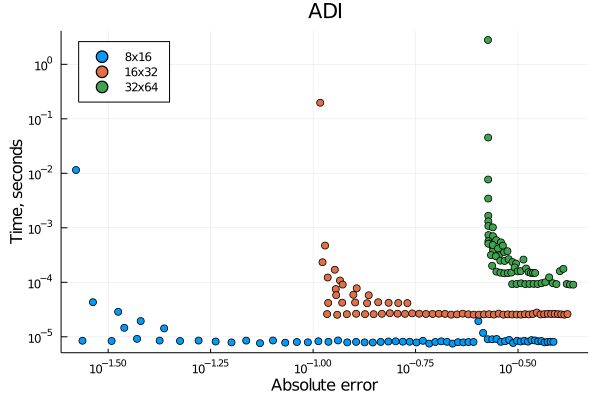

In [298]:
scatter(timeerr_8x16[2], timeerr_8x16[1],
        xaxis = :log10, yaxis = :log10,
        label = "8x16",
        xlabel = "Absolute error",
        ylabel = "Time, seconds",
        legend = :topleft,
        title = "ADI")
scatter!(timeerr_16x32[2], timeerr_16x32[1],
        label = "16x32")
scatter!(timeerr_32x64[2], timeerr_32x64[1],
        label = "32x64")

In [299]:
#savefig("Explicit times.pdf")
#savefig("ADI times.pdf")